# Time Series Demo: CDCV and MGC-TS
In this notebook, we demonstrate the cross-distance covariance (`cdcv`) test and the multiscale graph correlation time series (`mgc_ts`) test for independence of time series.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

from mgcpy.independence_tests.cdcv import CDCV
from mgcpy.independence_tests.mgc_ts import MGC_TS
from mgcpy.independence_tests.mgc import MGC

**Function to compute and print CDCV nd MGC_TS output values, given X and Y:**

In [6]:
def compute_cdcv(X, Y, max_lag):
    cdcv = CDCV(max_lag = max_lag, which_test = 'unbiased')
    cdcv_statistic, _ = cdcv.test_statistic(X, Y)
    p_value, _ = cdcv.p_value(X, Y)

    print("CDCV test statistic:", cdcv_statistic)
    print("P Value:", p_value)
    return cdcv_statistic, p_value

def compute_mgc_ts(X, Y, max_lag):
    mgc_ts = MGC_TS(max_lag = max_lag)
    mgc_ts_statistic, _ = mgc_ts.test_statistic(X, Y)
    p_value, _ = mgc_ts.p_value(X, Y)

    print("MGC TS test statistic:", mgc_ts_statistic)
    print("P Value:", p_value)
    return mgc_ts_statistic, p_value

**Example: simulate data `X` and `Y` in the form of `n`-by-`p` and `n`-by-`q` matrices respectively, where `n` is the sample size.**

In [7]:
n = 25
p = 10
q = 5
max_lag = 0 # 'M' parameter for CDCV test.

X = np.array([1,2,3,4,5,6,7,8,9,10]).reshape(10, 1)
Y = np.array([1,2,3,4,5,6,7,8,9,10]).reshape(10, 1)

CDCV_statistic, p_value = compute_cdcv(X, Y, max_lag)
MGC_TS_statistic, p_value = compute_mgc_ts(X, Y, max_lag)

CDCV test statistic: 44.00000000000001
P Value: 0.0
MGC TS test statistic: 10.0
P Value: 0.0


In the following cells, we simulate different time series processes and estimate the power of the test at varying choices of sample size. Additionally, we compare against the Ljung-Box test of correlation.

**Function to simulate time series.**

In [8]:
def indep_ar1(n):
    # X_t and Y_t are univarite AR(1) with phi = 0.5.
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = 0.5*X[t-1] + epsilons[t]
        Y[t] = 0.5*Y[t-1] + etas[t]
        
    return X, Y

In [9]:
def lin_dep_ar1(n):
    # X_t and Y_t are together a bivarite AR(1) with Phi = [0 0.5; 0.5 0].
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = 0.5*Y[t-1] + epsilons[t]
        Y[t] = 0.5*X[t-1] + etas[t]
        
    return X, Y

In [10]:
def nonlin_dep_ma1(n):
    # X_t and Y_t are together a bivarite NMA(1).
    
    # Innovations.
    epsilons = np.random.normal(0.0, 1.0, n)
    etas = np.random.normal(0.0, 1.0, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # MA(1) process.
    for t in range(1,n):
        X[t] = epsilons[t]*epsilons[t-1]*etas[t-1]
        Y[t] = etas[t]*etas[t-1]*epsilons[t-1]
        
    return X, Y

**Function to run the Ljung-Box test of dependence using cross-correlations.**

In [11]:
def ljung_box(X, Y, max_lag, alpha):
    n = len(X)
    test_statistic = (np.corrcoef(X,Y)[1,0])**2 / n
    for j in range(1,max_lag+1):
            lead_X = X[j:n]
            lag_Y = Y[0:(n-j)]
            test_statistic += (np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j)

            lag_X = X[0:(n-j)]
            lead_Y = Y[j:n]
            test_statistic += (np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j)
    test_statistic *= (n*(n+2))
    
    critical_value = chi2.ppf(1-alpha, df = 2*max_lag+1)
    return(test_statistic >= critical_value)

**Compute power curves of the test on each process.**

In [12]:
def power_curve(sample_sizes, powers_cdcv, powers_lb, powers_mgc_ts, alpha, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    
    plt.plot(sample_sizes, powers_cdcv, linestyle = '-', color = 'blue')
    plt.plot(sample_sizes, powers_lb, linestyle = ':', color = 'red')
    plt.plot(sample_sizes, powers_mgc_ts, linestyle = '--', color = 'green')
    ax.legend(['CDCV', 'LB', 'MGC-TS'], loc = 'upper left')
    
    ax.axhline(y=alpha, color = 'black', linestyle = '--')
    ax.axhline(y=1, color = 'black', linestyle = '--')
    plt.show()

**Full experiment, simulating the above time series, and counting the rejections by each test (as a function of `n`).**

Estimating power at sample size:  10..........
Estimating power at sample size:  20..........
Estimating power at sample size:  30..........
Estimating power at sample size:  40..........
Estimating power at sample size:  50..........
Estimating power at sample size:  60..........
Estimating power at sample size:  70..........
Estimating power at sample size:  80..........
Estimating power at sample size:  90..........
Estimating power at sample size:  100..........


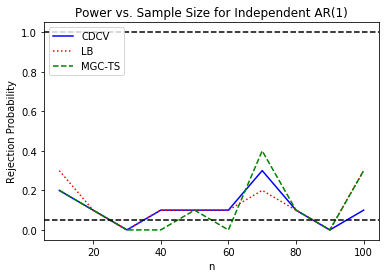

Estimating power at sample size:  10..........
Estimating power at sample size:  20..........
Estimating power at sample size:  30..........
Estimating power at sample size:  40..........
Estimating power at sample size:  50..........
Estimating power at sample size:  60..........
Estimating power at sample size:  70..........
Estimating power at sample size:  80..........
Estimating power at sample size:  90..........
Estimating power at sample size:  100..........


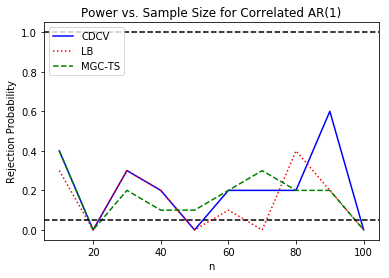

Estimating power at sample size:  10..........
Estimating power at sample size:  20..........
Estimating power at sample size:  30..........
Estimating power at sample size:  40..........
Estimating power at sample size:  50..........
Estimating power at sample size:  60..........
Estimating power at sample size:  70..........
Estimating power at sample size:  80..........
Estimating power at sample size:  90..........
Estimating power at sample size:  100..........


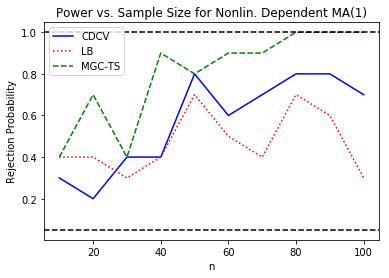

In [13]:
# Experimental parameters.
sample_sizes  = range(10,110,10)
num_sims      = 10
num_bootstrap = 10
alpha         = 0.05
maxlag        = 0

cdcv   = CDCV(max_lag = maxlag)
mgc_ts = MGC_TS(max_lag = maxlag)

powers_cdcv   = np.zeros(len(sample_sizes))
powers_lb     = np.zeros(len(sample_sizes))
powers_mgc_ts = np.zeros(len(sample_sizes))

sims      = [indep_ar1, 
             lin_dep_ar1, 
             nonlin_dep_ma1]
sim_names = ["Power vs. Sample Size for Independent AR(1)", 
             "Power vs. Sample Size for Correlated AR(1)", 
             "Power vs. Sample Size for Nonlin. Dependent MA(1)"]

# For each simulated process:
for s in range(len(sims)):
    sim_type = sims[s]
    # For each choice of sample size n:
    for i in range(len(sample_sizes)):
        rejects_cdcv   = 0.0
        rejects_lb     = 0.0
        rejects_mgc_ts = 0.0
        n = sample_sizes[i]
        print("Estimating power at sample size: ", str(n), end = "")
        
        # Simulate time series and count rejections.
        for t in range(num_sims):
            print('.', end='')
            X, Y = sim_type(n)
            
            # CDCV
            p_value, _ = cdcv.p_value(X, Y, replication_factor = num_bootstrap)
            if p_value < alpha:
                rejects_cdcv += 1
                
            # MGC TS
            p_value, _ = mgc_ts.p_value(X, Y, replication_factor = num_bootstrap)
            if p_value < alpha:
                rejects_mgc_ts += 1
                
            # Ljung-Box
            if ljung_box(X, Y, maxlag, alpha):
                rejects_lb += 1
        
        powers_cdcv[i] = rejects_cdcv/num_sims
        powers_lb[i] = rejects_lb/num_sims
        powers_mgc_ts[i] = rejects_mgc_ts/num_sims
        print("")
        
    # Display power estimates.
    power_curve(sample_sizes, powers_cdcv, powers_lb, powers_mgc_ts, alpha, sim_names[s])